In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime

### Define The Design

In [62]:
# One-sided Group Sequential Test with the parameters:
# looks=20
# alpha=0.05
# beta=0.2
# efficacy bounds <- sfPower(3)
# futility bounds <- sfPower(1.5)

# DO NOT change these parameters (the bounds depend on these specific inputs)
looks = 15
alpha = 0.05
beta = 0.2

efficacy_bounds = [4.1762944030231255, 3.7025230171140833, 3.412425304852192, 3.1895681348267497, 3.0031218982900745, 2.8399266737175886, 2.6929234835783804, 2.5577649883333042, 2.431459298875911, 2.311681621991688, 2.196258000806301, 2.082528128444262, 1.9659412442753499, 1.8350075992575465, 1.6334665423394543]
futility_bounds = [-2.0206408409400276, -1.4707036032594498, -1.0732569645904761, -0.743251234434765, -0.45487107273772087, -0.1954083140723849, 0.04257918914093326, 0.26390860462831767, 0.4719279542742342, 0.6691190062543414, 0.8575163049993835, 1.03918634140849, 1.2173221479798773, 1.4004097678324625, 1.6334665423394543]
ppl = 0.07516559068404118

# 1. Define Group Sequential Test

In [116]:
def run_sequential(data, column_names, control_name, control_proportion, kpi_type, N=None, immature=False, internal_SRM=True):
    """
    Run a group sequential test on experimental data.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the experimental observations. Must include
        all columns referenced in `column_names`.

    column_names : dictionary
        Dictionary of column names required by the sequential test.
        All names must be strings and must exist in `data.columns`.

    control_name : str
        Name of the control group. Must exist in `data[column_names['group']]`.

    control_proportion : float
        Proportion of the control group in the total sample size (must be a float in the range (0, 1)).

    kpi_type : str
        Type of KPI. Accepted values:
        - "binary": KPI column is 0/1 (success/failure)
        - "continuous": KPI column is a real-valued metric
        No other values are allowed.

    N : int, optional
        The *fixed-horizon* total sample size for both group (must be a positive integer).

    immature : bool
    Indicates whether enough time has passed since the last exposure
    to expect conversions in the data.
    - True:  Assume insufficient time has passed for some conversions.
    - False: Assume sufficient time for conversions has passed.

    Raises
    ------
    TypeError
        If any argument is of the wrong type.

    ValueError
        If any numeric argument is out of its required range or if column names are missing.
    """

    # --- Input validation ---

    # 1. Validate data
    if not isinstance(data, pd.DataFrame):
        raise TypeError(f"`data` must be a pandas DataFrame, got {type(data).__name__}")

    # 2. Validate column_names
    if not isinstance(column_names, dict):
        raise TypeError("`column_names` must be a dictionary")
    for key, col in column_names.items():
        if key != 'KPI_time':
            if col not in data.columns:
                raise ValueError(f"Column `{col}` for key `{key}` not found in DataFrame `data`")
        elif immature == True:
            if col not in data.columns:
                raise ValueError(f"Column `{col}` for key `{key}` not found in DataFrame `data`")

    # 3. Validate control_name
    if not isinstance(control_name, str):
        raise TypeError(f"`control_name` must be a string, got {type(control_name).__name__}")
    if control_name not in data[column_names['group']].unique():
        raise ValueError(f"`control_name` must be one of {data[column_names['group']].unique()}, got `{control_name}`")
    
    # 4. Validate control_proportion
    if not isinstance(control_proportion, float):
        raise TypeError(f"`control_proportion` must be a float, got {type(control_proportion).__name__}")
    if not (0 < control_proportion < 1):
        raise ValueError(f"`control_proportion` must be in the range (0, 1), got {control_proportion}")

    # 5. Validate kpi_type
    valid_kpis = {"binary", "continuous"}
    if not isinstance(kpi_type, str) or kpi_type.lower() not in valid_kpis:
        raise ValueError(f"`kpi_type` must be one of {valid_kpis}, got `{kpi_type}`")
    kpi_type = kpi_type.lower()

    # 6. Validate N
    if not isinstance(N, int):
        raise TypeError(f"`N` must be an integer, got {type(N).__name__}")
    if N <= 0:
        raise ValueError(f"`N` must be > 0, got {N}")

    # 7. Validate immature
    if not isinstance(immature, bool):
        raise TypeError(f"`immature` must be a boolean, got {type(immature).__name__}")

    # --- Run Test ---

    print(f'Non‐sequential test N per arm: {N}')
    increment = int(ppl * N + 1)
    print(f'Increase in group\'s size per look: {increment}\n')

    # Prepare the data
    df = data.copy()
    column_names_inv = {v: k for k, v in column_names.items()}
    df.rename(columns=column_names_inv, inplace=True)

    df['exposure_time'] = pd.to_datetime(df['exposure_time'])
    df.sort_values(by='exposure_time', inplace=True)

    if immature:
        df['KPI_time'] = pd.to_datetime(df['KPI_time'])
        df['KPI_time'] = df['KPI_time'].fillna(df['exposure_time'])

    # Run test
    stats_sequence = []
    conclusion_reached = False
    for i in range(looks):

        current_size = (i+1) * increment
        if current_size > len(df):
            print(f'**Data is sufficient for only {i} looks**\n')
            break

        df_cur = df.iloc[:current_size].copy()

        if not immature:
            KPI_col = 'KPI'
        else:
            threshold = df_cur['exposure_time'].max()
            df_cur['Adjusted_KPI'] = df_cur['KPI'] * (df_cur['KPI_time'] <= threshold)
            KPI_col = 'Adjusted_KPI'
        
        Y_control = df_cur[df_cur['group'] == control_name][KPI_col]
        Y_treatment = df_cur[df_cur['group'] != control_name][KPI_col]

        mean_control = Y_control.mean()
        mean_treatment = Y_treatment.mean()

        std_control = Y_control.std()
        std_treatment = Y_treatment.std()
        std_difference = np.sqrt((std_treatment**2 / current_size) + (std_control**2 / current_size))

        statistic = (mean_treatment - mean_control) / std_difference
        stats_sequence.append(statistic)

        if not conclusion_reached:
            if statistic > efficacy_bounds[i]:
                print(f'**Stop for efficacy after {i+1} looks** \n(Positive effect was demonstrated)\n')
                conclusion_reached = True
            elif statistic < futility_bounds[i]:
                print(f'**Stop for futility after {i+1} looks** \n(No sufficiently large positive effect was demonstrated)\n')
                conclusion_reached = True

    if i == 0:
        print('**No looks were performed**\n')
        return
    
    print(f'Mean KPI for control group: {mean_control:.4f}')
    print(f'Mean KPI for treatment group: {mean_treatment:.4f}')
    print(f'Observed relative lift: {mean_treatment / mean_control - 1:.2%}')

    # --- SRM ---
    if internal_SRM and i > 0:
        p_hat = len(Y_control) / current_size
        p_std = np.sqrt(p_hat * (1 - p_hat) / current_size)
        SRM_statistic = (p_hat - control_proportion) / p_std
        p_value = 2 * norm.sf(np.abs(SRM_statistic))
        
        print(f'\nSRM p-value: {p_value:.3f}{", no problem found." if p_value >= 0.1 else ""}')
        if p_value < 0.1:
            print('**SRM problem is significant**')

    # --- Plot Results ---
    plt.figure(figsize=(8, 4))

    x = np.arange(1, looks+1)
    plt.plot(x, efficacy_bounds, color='g', label='Efficacy')
    plt.plot(x, futility_bounds, color='r', label='Futility')
    plt.plot(x[:len(stats_sequence)], stats_sequence, color='b',
             marker='o', markersize=4, label='Statistic')

    plt.axhline(y=0, color='k', linestyle='--', linewidth=0.7)

    ax = plt.gca()
    ymin = np.min(np.concatenate((futility_bounds, stats_sequence))) - 1
    ymax = np.max(np.concatenate((efficacy_bounds, stats_sequence))) + 1
    ax.fill_between(x, efficacy_bounds, ymax,
                    where=efficacy_bounds <= ymax,
                    color='green', alpha=0.1)
    ax.fill_between(x, ymin, futility_bounds,
                    where=futility_bounds >= ymin,
                    color='red', alpha=0.1)

    plt.title('Sequencial Test')
    plt.xlabel('Look')
    plt.ylabel('Statistic')
    plt.xticks(x)
    plt.xlim(1, looks)
    plt.ylim(ymin, ymax)
    plt.legend(loc='lower right')
    plt.show()

### Load the Data

In [110]:
data = pd.read_csv("C:/Users/user/Documents/Bell/Datasets/AutoDS/trustpilot population.csv")

### Run Group Sequential Test

Non‐sequential test N per arm: 94000
Increase in group's size per look: 7066

**Stop for futility after 15 looks** 
(No sufficiently large positive effect was demonstrated)

Mean KPI for control group: 0.3097
Mean KPI for treatment group: 0.3112
Observed relative lift: 0.48%

SRM p-value: 0.990, no problem found.


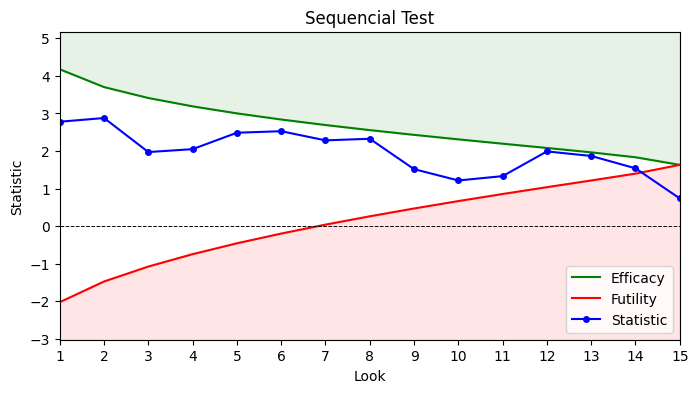

In [117]:
# Replace with the relevant column names
column_names = {'exposure_time': 'EXPOSURE_DATE',
                'group': 'VARIANT',
                'KPI': 'KPI_ACTION',
                'KPI_time': 'KPI_DATE'}

run_sequential(data=data,
               column_names=column_names,
               control_name='"Control"',
               control_proportion=0.5,
               kpi_type='binary',
               N=94000,
               immature=False)

# 2. Multivariate Sequential Testing

In [143]:
def multivariate_sequential(data, column_names, control_name, proportions, kpi_type, N, immature=False):
    """
    Run a multivariate group sequential test on experimental data.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the experimental observations. Must include
        all columns referenced in `column_names`.

    column_names : dictionary
        Dictionary of column names required by the sequential test.
        All names must be strings and must exist in `data.columns`.

    control_name : str
        Name of the control group. Must exist in `data[column_names['group']]`.
    
    proportions : dictionary
        Dictionary of proportions for each group in the experiment.
        The keys are group names and the values are their respective proportions.
        The sum of all proportions must equal 1.
    
    kpi_type : str
        Type of KPI. Accepted values:
        - "binary": KPI column is 0/1 (success/failure)
        - "continuous": KPI column is a real-valued metric
        No other values are allowed.

    N : int
        The *fixed-horizon* total sample size for both groups (must be a positive integer).
    
    immature : bool
        Indicates whether enough time has passed since the last exposure
        to expect conversions in the data.
        - True: Assume insufficient time has passed for some conversions.
        - False: Assume sufficient time for conversions has passed.

    Raises
    ------
    TypeError
        If any argument is of the wrong type.

    ValueError
        If any numeric argument is out of its required range or if column names are missing.
    """

    # --- Input validation ---

    # 1. Validate data
    if not isinstance(data, pd.DataFrame):
        raise TypeError(f"`data` must be a pandas DataFrame, got {type(data).__name__}")

    # 2. Validate column_names
    if not isinstance(column_names, dict):
        raise TypeError("`column_names` must be a dictionary")
    for key, col in column_names.items():
        if key != 'KPI_time':
            if col not in data.columns:
                raise ValueError(f"Column `{col}` for key `{key}` not found in DataFrame `data`")
        elif immature == True:
            if col not in data.columns:
                raise ValueError(f"Column `{col}` for key `{key}` not found in DataFrame `data`")
    
    # 3. Validate control_name
    if not isinstance(control_name, str):
        raise TypeError(f"`control_name` must be a string, got {type(control_name).__name__}")
    if control_name not in data[column_names['group']].unique():
        raise ValueError(f"`control_name` must be one of {data[column_names['group']].unique()}, got `{control_name}`")
    
    # 4. Validate proportions
    if not isinstance(proportions, dict):
        raise TypeError("`proportions` must be a dictionary")
    if not all(isinstance(k, str) for k in proportions.keys()):
        raise TypeError("All keys in `proportions` must be strings")
    if not all(isinstance(v, float) for v in proportions.values()):
        raise TypeError("All values in `proportions` must be floats")
    if not np.isclose(sum(proportions.values()), 1.0):
        raise ValueError("The sum of all proportions in `proportions` must equal 1")
    if set(data[column_names['group']].unique()) != set(proportions.keys()):
        raise ValueError("Keys in `proportions` must match unique values in `data[column_names['group']]`")
    for group, proportion in proportions.items():
        if not (0 < proportion < 1):
            raise ValueError(f"Proportion for group `{group}` must be in the range (0, 1), got {proportion}")
        
    # 5. Validate kpi_type
    valid_kpis = {"binary", "continuous"}
    if not isinstance(kpi_type, str) or kpi_type.lower() not in valid_kpis:
        raise ValueError(f"`kpi_type` must be one of {valid_kpis}, got `{kpi_type}`")
    kpi_type = kpi_type.lower()

    # 6. Validate N
    if not isinstance(N, int):
        raise TypeError(f"`N` must be an integer, got {type(N).__name__}")
    if N <= 0:
        raise ValueError(f"`N` must be > 0, got {N}")
    
    # 7. Validate immature
    if not isinstance(immature, bool):
        raise TypeError(f"`immature` must be a boolean, got {type(immature).__name__}")
    
    # --- Run Test ---
    variates = list(proportions.keys())
    treatments = [group for group in variates if group != control_name]

    for treatment in treatments:
        print(f'- - - Running test for treatment group: {treatment}- - -\n')
        data_treatment = data[data[column_names['group']].isin([control_name, treatment])].copy()
        control_proportion = proportions[control_name] / (proportions[control_name] + proportions[treatment])
        relative_N = int(N * (proportions[control_name] + proportions[treatment]))
        run_sequential(data=data_treatment,
                       column_names=column_names,
                       control_name=control_name,
                       control_proportion=control_proportion,
                       kpi_type=kpi_type,
                       N=relative_N,
                       immature=immature,
                       internal_SRM=True)
        print('\n' + '-'*60 + '\n')  # Separator between treatments

    # --- SRM Check ---


In [ ]:
# Replace with true Data
data_multi = data.copy()
data_multi['random_number'] = np.random.binomial(1, 0.2, size=len(data_multi))
data_multi['VARIANT'] = data_multi[['VARIANT', 'random_number']].apply(
    lambda x:
        '"Control"' if x['VARIANT'] == '"Control"' else
        '"Variation-1"' if x['random_number'] == 0 else
        '"Variation-2"',
    axis=1
)

- - - Running test for treatment group: "Variation-1"- - -

Non‐sequential test N per arm: 84600
Increase in group's size per look: 6360

**Stop for futility after 15 looks** 
(No sufficiently large positive effect was demonstrated)

Mean KPI for control group: 0.3096
Mean KPI for treatment group: 0.3111
Observed relative lift: 0.47%

SRM p-value: 0.881, no problem found.


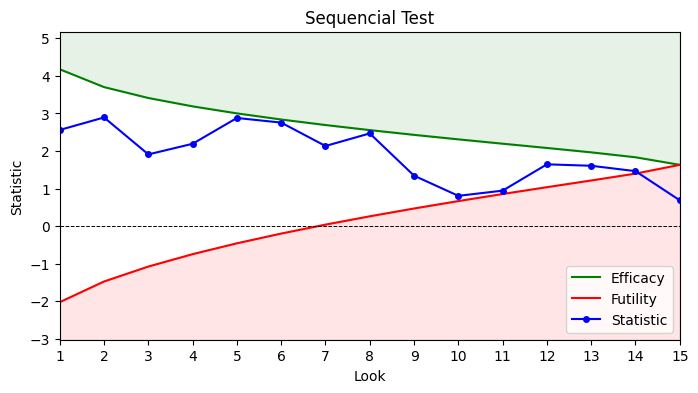


------------------------------------------------------------

- - - Running test for treatment group: "Variation-2"- - -

Non‐sequential test N per arm: 56400
Increase in group's size per look: 4240

**Stop for efficacy after 11 looks** 
(Positive effect was demonstrated)

Mean KPI for control group: 0.3097
Mean KPI for treatment group: 0.3121
Observed relative lift: 0.80%

SRM p-value: 0.717, no problem found.


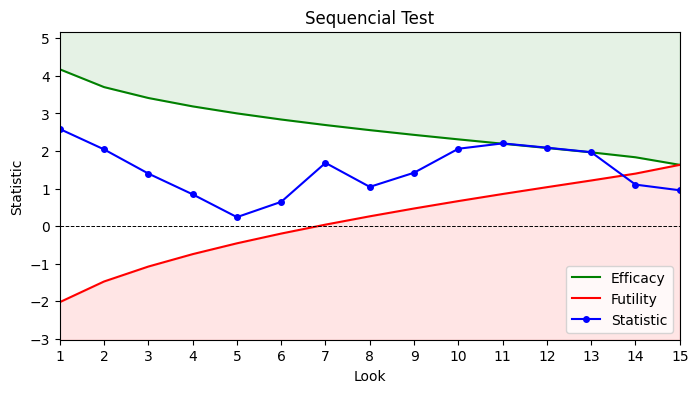


------------------------------------------------------------



In [149]:
# Replace with the relevant column names
column_names = {'exposure_time': 'EXPOSURE_DATE',
                'group': 'VARIANT',
                'KPI': 'KPI_ACTION',
                'KPI_time': 'KPI_DATE'}

proportions = {'"Control"': 0.5,
               '"Variation-1"': 0.4,
               '"Variation-2"': 0.1}

multivariate_sequential(data=data_multi,
                        column_names=column_names,
                        control_name='"Control"',
                        proportions=proportions,
                        kpi_type='binary',
                        N=94000,
                        immature=False)

In [115]:
data['VARIANT'].unique()

array(['"Variation-1"', '"Control"'], dtype=object)